In [3]:
import torch.utils.data as data
import os
import cv2
from matplotlib import pyplot as plt  
import glob, os
from PIL import Image
from torchvision import transforms 
import numpy as np
from PIL import Image
%matplotlib inline
import random


random.seed(20)
CAR_MEAN = [0.6982, 0.6909, 0.6840]
CAR_STD = [0.2264, 0.2307, 0.2283]
tr_img = transforms.Compose([transforms.Resize((128,128))
,transforms.ToTensor()
,transforms.Normalize(CAR_MEAN, CAR_STD)])
tr_msk = transforms.Compose([transforms.Resize((128,128))
,transforms.ToTensor()])


class MyDataSet(data.Dataset):
    def __init__(self, folder, exts=['jpg', 'png'], target_ext="jpg",
                 transform_img=None, transform_mask=None, ratio=1.0, train=True):
        super(MyDataSet, self).__init__()
        (self.imgs, self.masks) = self._get_image_mask_pair(folder, exts, target_ext,
                                                            ratio, train=train, tag="_mask")
        self.transform_img = transform_img
        self.transform_mask = transform_mask
        
    def __getitem__(self, index):
            if 1:
            #try:
                #print(self.imgs[index], self.masks[index]))
                img = Image.open(self.imgs[index])
                mask = Image.open(self.masks[index])
            #except:
            #    print("Failed to load data in MyDadaSet")
            if self.transform_img:
                img = self.transform_img(img)
            if self.transform_mask:
                mask = self.transform_mask(mask)
                mask = (mask == 0).float()
            return img, mask

    def __len__(self):
        return len(self.imgs)
    
    def _get_image_mask_pair(self, folder, exts, target_ext, ratio, train, tag="_mask"):
        source = self._get_files(folder, exts)
        imgs = []
        masks = []
        for item in source:
            img_path, fname = os.path.split(item)
            fname, ext = os.path.splitext(fname)
            mask = img_path + tag + "/" + fname + tag + "." + target_ext
            if os.path.isfile(mask):
                imgs.append(item)
                masks.append(mask)  
        rand_idx = random.choices(range(len(imgs)), k = int(len(imgs)))
        train_bc = int(len(imgs)*ratio)
        if train: 
            train_bc = int(len(imgs)*ratio)
            imgs = [imgs[item] for item in rand_idx[0:train_bc]]
            masks = [masks[item] for item in rand_idx[0:train_bc]]
        else:
            train_bc = int(len(imgs)*(1-ratio))
            imgs = [imgs[item] for item in rand_idx[train_bc:]]
            masks = [masks[item] for item in rand_idx[train_bc:]]                      
        return (imgs, masks)                            
    def _get_files(self, folder, exts):
        files = []
        for filename in glob.iglob(folder+"/**", recursive=True):
            if os.path.isfile(filename): # filter dirs
                base, ext = os.path.splitext(filename)
                if len(ext)>0:
                    if ext[1:] in exts:
                        files.append(filename)
        return files

In [4]:
ds_train = MyDataSet('./datas/train',target_ext="gif", transform_img=tr_img,
               transform_mask=tr_msk, ratio=0.1, train=True)
dataset_sizes = len(ds_train)
print ("train data number: ", dataset_sizes)
ds_val = MyDataSet('./datas/train',target_ext="gif", transform_img=tr_img,
               transform_mask=tr_msk, ratio=0.9, train=False)
valset_sizes = len(ds_val)
print ("validation data number: ",valset_sizes)

train data number:  3
validation data number:  29


In [5]:
loader = data.DataLoader(
    ds_train,
    batch_size=20,
    num_workers=1,
    shuffle=True
)
loader_val = data.DataLoader(
    ds_val,
    batch_size=20,
    num_workers=1,
    shuffle=True
)

In [6]:
def imshow(inp, image=True):
    """Imshow for Tensor."""
    
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(CAR_MEAN)
    std = np.array(CAR_STD)
    if image:
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)
    plt.imshow(inp)

In [7]:
def imconvert(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(CAR_MEAN)
    std = np.array(CAR_STD)

    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)  
    return inp

In [8]:
import torch
import torch.nn as nn
import time
from torch.autograd import Variable


def Convs(cin, cout):
    func = nn.Sequential(
        nn.Conv2d(cin, cout, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(cout, cout, kernel_size=3, stride=1, padding=1),
        nn.ReLU()
    )
    return func

class Sunet(nn.Module):
    def __init__(self, cout=1):
        super(Sunet, self).__init__()
        #down
        self.maxpool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dconvs0 = Convs(3, 16)
        self.dconvs1 = Convs(16, 32)
        self.dconvs2 = Convs(32, 64)
        self.dconvs3 = Convs(64, 128)
        self.dconvs4 = Convs(128, 256)
        #up
        self.up3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, stride=2, kernel_size=2)
        self.uconvs3 = Convs(256, 128)
        self.up2 = nn.ConvTranspose2d(in_channels=128, out_channels=64, stride=2, kernel_size=2)
        self.uconvs2 = Convs(128, 64)
        self.up1 = nn.ConvTranspose2d(in_channels=64, out_channels=32, stride=2, kernel_size=2)
        self.uconvs1 = Convs(64, 32)
        self.up0 = nn.ConvTranspose2d(in_channels=32, out_channels=16, stride=2, kernel_size=2)
        self.uconvs0 = Convs(32, 16)
        #final
        self.output = nn.Conv2d(in_channels=16, out_channels=cout, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
        self.linear = nn.Linear(in_features=16384, out_features=16384)
        
        
    def forward(self, img):
        #down
        d0_t = self.dconvs0(img)
        d1 = self.maxpool2d(d0_t)
        d1_t = self.dconvs1(d1)
        d2 = self.maxpool2d(d1_t)
        d2_t = self.dconvs2(d2)
        d3 = self.maxpool2d(d2_t)
        d3_t = self.dconvs3(d3)
        d4 = self.maxpool2d(d3_t)
        d4_t = self.dconvs4(d4)
        #up
        u3 = self.up3(d4_t)
        u3_t = self.uconvs3(torch.cat([u3, d3_t], 1))
        u2 = self.up2(d3_t)
        u2_t = self.uconvs2(torch.cat([u2, d2_t], 1))
        u1 = self.up1(d2_t)
        u1_t = self.uconvs1(torch.cat([u1, d1_t], 1))
        u0 = self.up0(d1_t)
        u0_t = self.uconvs0(torch.cat([u0, d0_t], 1))
        out = self.output(u0_t)
        return self.sigmoid(out)

In [9]:
dataloaders = {'train':loader, 'valid':loader_val}
model_ft = Sunet()
is_cuda= False
if torch.cuda.is_available():
    is_cuda = True
    model_ft.cuda()
print("is Cuda: ", is_cuda)  
model_ft.load_state_dict(torch.load('./sim_unet_final.pth'))
model_ft.eval()

is Cuda:  True


Sunet(
  (maxpool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dconvs0): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (dconvs1): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (dconvs2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (dconvs3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (dconvs4): Sequential(
    (0): Conv2d(128, 256, kernel

In [10]:
validation_iter = iter(dataloaders['valid'])

In [11]:
in_img, out_mask = validation_iter.next()
if is_cuda:
    out = model_ft(in_img.cuda())
else:
    out = model_ft(in_img)    

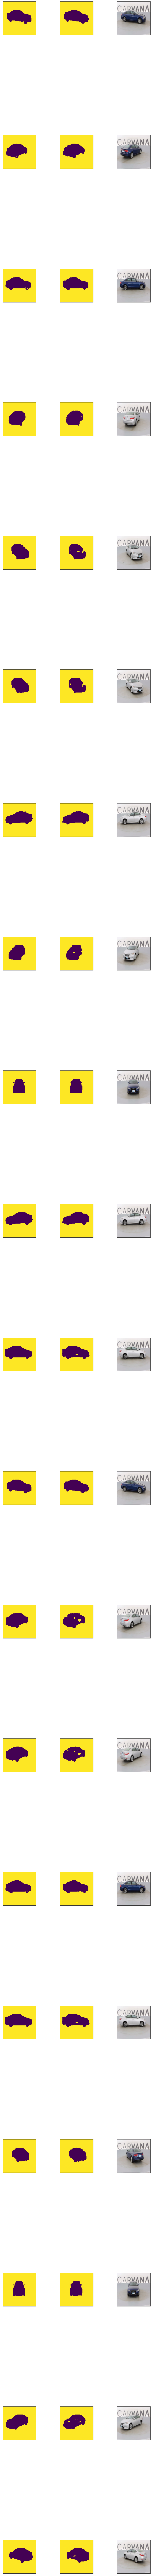

In [12]:
fig = plt.figure(figsize=(20,50))
fig.subplots_adjust(left=0.5,right=1,bottom=0,top=3,hspace=3,wspace=0.0)
Row = 20

if is_cuda:
    for i in range(Row):
        ax = fig.add_subplot(Row,3,1+i*3,xticks=[],yticks=[])
        ax.imshow(out_mask[i].detach().cpu().squeeze(0))      
        ax = fig.add_subplot(Row,3,2+i*3,xticks=[],yticks=[])
        ax.imshow(out[i].detach().cpu().squeeze(0)>0.5)  
        cimg = imconvert(in_img[i])
        ax = fig.add_subplot(Row,3,3+i*3,xticks=[],yticks=[])
        ax.imshow(cimg) 
else:        
    for i in range(Row):
        ax = fig.add_subplot(Row,3,1+i*3,xticks=[],yticks=[])
        ax.imshow(out_mask[i].squeeze(0))      
        ax = fig.add_subplot(Row,3,2+i*3,xticks=[],yticks=[])
        ax.imshow(out[i].squeeze(0)>0.5)  
        cimg = imconvert(in_img[i])
        ax = fig.add_subplot(Row,3,3+i*3,xticks=[],yticks=[])
        ax.imshow(cimg)     